# Do you have a Gurobi WLS?
Use the cell below to add your license information and carry on. 

If you don't, no problem. You can work though a lighter version of this notebook using a [free limited license here](https://colab.research.google.com/github/Gurobi/modeling-examples/blob/master/price_optimization/price_optimization_gurobiML.ipynb).

In [33]:

params = {
"WLSACCESSID": ---- ,
"WLSSECRET":  ---- ,
"LICENSEID": ---- ,
}

# Part Two: Avocado Pricing and Supply Using Mathematical Optimization

This is a second part of an example on price optimization: [How Much Is Too Much? Avocado Pricing and Supply Using Mathematical Optimization](https://github.com/Gurobi/modeling-examples/tree/master/price_optimization)

In the first part, an ordinary linear regression model (OLS) was used to establish the relationship between price and demand based on data from the [Hass Avocado Board](https://hassavocadoboard.com/) (HAB).

Part Two replaces the OLS model with a trained `Scikit-learn` model and uses the [Gurobi Machine Learning](https://gurobi-machinelearning.readthedocs.io/en/stable/#) package to embed it in a Gurobi optimization model.

In this example, we will also use `gurobipy-pandas`, which is another Gurobi open-source package and serves as a convenient (and optional) wrapper to connect pandas with gurobipy.

If you are already familiar with the example from the other notebook, you can jump directly to [building the regression model](#Part-2:-Predict-the-Sales)
and then to [formulating the optimization problem](#Part-3:-Optimize-for-Price-and-Supply-of-Avocados).

**Goal**: Develop a data science and decision-making pipeline for pricing and distribution of avocados to maximize revenue.

To accomplish this, the notebook will walk trough three stages:

1. A quick review of the HAB data
2. Build a prediction model for avocado demand as a function of price, region, year and seasonality.
3. Design an optimization model that sets the optimal price and supply quantity to maximize the net revenue while incorporating transportation and costs.

## Load the Packages and Prepare the Dataset

Just as in the first example, we use real HAB sales data.


In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The dataset from HAB contains sales data for the years 2019-2022. This data is augmented by a previous download from HAB available on
[Kaggle](https://www.kaggle.com/datasets/timmate/avocado-prices-2020) with sales for the years 2015-2018.

This notebook will skip a lot of the preprocessing from the first version of this example.

In [3]:
data_url = "https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/"
avocado = pd.read_csv(data_url+"HAB_data_2015to2022.csv")
avocado["date"] = pd.to_datetime(avocado["date"])
avocado = avocado.sort_values(by="date")
avocado

,date,units_sold,price,region,year,month,peak
0,2015-01-04,3.382800,1.020000,Great_Lakes,2015,1,0
1,2015-01-04,2.578275,1.100000,Midsouth,2015,1,0
2,2015-01-04,5.794411,0.890000,West,2015,1,0
3,2015-01-04,3.204112,0.980000,Southeast,2015,1,0
4,2015-01-04,0.321824,1.050000,Northern_New_England,2015,1,0
...,...,...,...,...,...,...,...
3396,2022-05-15,0.445830,1.513707,Northern_New_England,2022,5,1
3397,2022-05-15,4.150433,1.269883,SouthCentral,2022,5,1
3398,2022-05-15,4.668815,1.644873,Northeast,2022,5,1
3399,2022-05-15,32.745321,1.527357,Total_US,2022,5,1


One of the regions in the above data frame is `Total_US`, so we can create a list of regions, excluding the total, which can be used to subset the data now. It'll be used later in the example as well.

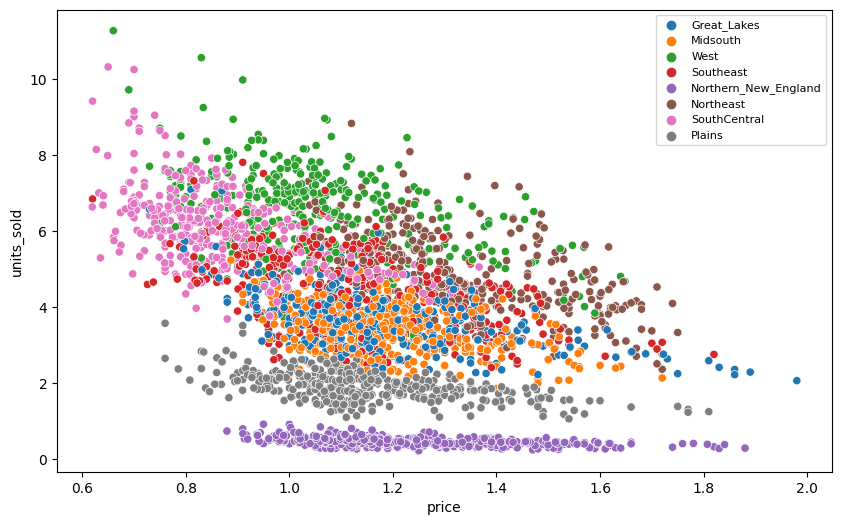

In [4]:
regions = [
    "Great_Lakes",
    "Midsouth",
    "Northeast",
    "Northern_New_England",
    "SouthCentral",
    "Southeast",
    "West",
    "Plains"
]
df = avocado[(avocado.region.isin(regions))] # & (avocado.peak==0)
df.drop(columns=['date']) #,'peak'

plt.figure(figsize=(10, 6))
r_plt = sns.scatterplot(data=df, x='price', y='units_sold', hue='region')
r_plt.legend(fontsize=8)
plt.show()

## Predict the Sales

In the first instance of this example, further analysis was done on the input data along with a few visualizations. Here, we will go directly to the predicive model training, starting with a random split of the dataset into $70\%$ training and $30\%$ testing data.

In [5]:
from sklearn.model_selection import train_test_split

X = df[["region", "price", "year", "peak"]]
y = df["units_sold"]
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1
)

Note that the region is a categorical variable and we will transform that variable using Scikit Learn's `OneHotEncoder`. We also use a standard scaler for prices and year index, combining all of the ese with `Column Transformer` built using `make_column_transformer`.

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

feat_transform = make_column_transformer(
    (OneHotEncoder(drop="first"), ["region"]),
    (StandardScaler(), ["price", "year"]),
    ("passthrough", ["peak"]),
    verbose_feature_names_out=False,
    remainder='drop'
)

The regression model is a pipeline consisting of the `Column Transformer` and the type of model we want to use for the regression. For comparison, we'll stick with a linear regression.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [8]:
reg = make_pipeline(feat_transform, LinearRegression())
scores = cross_val_score(reg, X_train, y_train, cv=5)
print("%0.4f R^2 with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

0.9022 R^2 with a standard deviation of 0.0101


In [9]:
# Find model score on test data
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"The R^2 value in the test set is {np.round(r2_score(y_test, y_pred),5)}")

The R^2 value in the test set is 0.91365


We can observe a good $R^2$ value in the test set. We will now train the fit to the full dataset.

In [10]:
reg.fit(X, y)
y_pred_full = reg.predict(X)
print(f"The R^2 value in the full dataset is {np.round(r2_score(y, y_pred_full),5)}")

The R^2 value in the full dataset is 0.90667


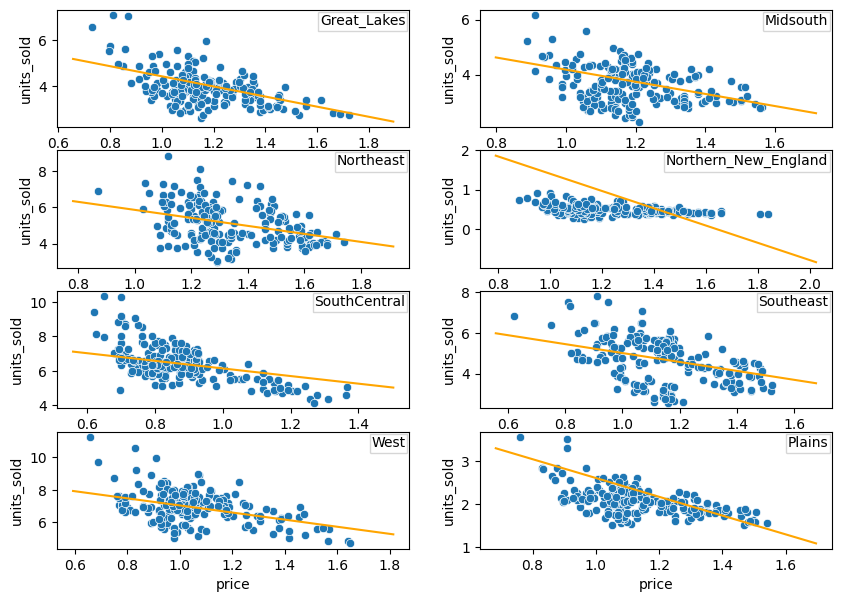

In [11]:
year = 2019
peak_or_not = 1
fig, axs = plt.subplots(4, 2, figsize=(10, 7))

for k in range(8):
  r = regions[k]
  i = k//2
  j = k%2
  X_r = df.loc[(df.region==r) & (df.peak==peak_or_not),["price", "year","units_sold"]]
  x_plt = X_r.price
  p_new = np.linspace(.9*min(x_plt),1.1*max(x_plt),50)
  x_new = pd.DataFrame(
      data={
          "year": year,
          "peak": peak_or_not,
          "region": r,
          "price": p_new
      },
      index=range(50)
  )
  x_new['units_sold'] = reg.predict(x_new)
  sns.lineplot(data=x_new, x='price', y='units_sold', c='orange', ax=axs[i,j])
  sns.scatterplot(data=X_r, x='price', y='units_sold', legend=0, ax=axs[i,j])
  axs[i, j].legend(title=r, loc='upper right', prop={'size': 3}, handles = []);

## Optimize for Price and Supply of Avocados

Here is a quick review of notation for the formulation of the mathematical optimization model. The subscript $r$ will be used to denote each region.
### Input parameters
- $d(p,r)$: predicted demand in region $r$ when the avocado price is $p$
- $B$: available avocados to be distributed across the regions
- $c_{waste}$: cost ($\$$) per wasted avocado
- $c^r_{transport}$: cost ($\$$) of transporting a avocado to region $r$
- $a_{min},a_{max}$: minimum and maximum price ($\$$) per avocado
- $b^r_{min},b^r_{max}$: minimum and maximum number of avocados allocated to region $r$

The following code sets values for these parameters. Feel free to adjust these to see how the solution to the optimization model will change.


In [12]:
# Sets and parameters
year = 2022
B = 30  # total amount of avocado supply
peak_or_not = 0  # 1 if it is the peak season; 0 if isn't
c_waste = 0.1  # the cost ($) of wasting an avocado
# the cost of transporting an avocado
c_transport = pd.Series(
    {
        "Great_Lakes": 0.3,
        "Midsouth": 0.1,
        "Northeast": 0.4,
        "Northern_New_England": 0.5,
        "SouthCentral": 0.3,
        "Southeast": 0.2,
        "West": 0.2,
        "Plains": 0.2,
    }, name='transport_cost'
)
c_transport = c_transport.loc[regions]

a_min = 0  # minimum avocado price
a_max = 2  # maximum avocado price

# Get the lower and upper bounds from the dataset for the price and the number of products to be stocked
data = pd.concat([c_transport,
                  df.groupby("region")["units_sold"].min().rename('min_delivery'),
                  df.groupby("region")["units_sold"].max().rename('max_delivery'),
                  df.groupby("region")["price"].max().rename('max_price'),], axis=1)

data

,transport_cost,min_delivery,max_delivery,max_price
Great_Lakes,0.3,2.063574,7.094765,1.980000
Midsouth,0.1,1.845443,6.168572,1.720000
Northeast,0.4,2.364424,8.836406,1.750000
Northern_New_England,0.5,0.219690,0.917984,1.880000
SouthCentral,0.3,3.687130,10.323175,1.366446
Southeast,0.2,2.197764,7.810475,1.820000
West,0.2,3.260102,11.274749,1.648013
Plains,0.2,1.058938,3.575499,1.810000


#### Install and import Gurobi packages

In [13]:
%%capture
%pip install gurobipy_pandas #this also installs gurobipy
%pip install gurobi-machinelearning
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr

### Create dataframe for the fixed features of the regression

We now start creating the input of the regression in the optimization models with the features that are fixed and use `gurobipy-pandas` that help to more easily create gurobipy models using pandas data.

First, create a dataframe with the features that are fixed in our optimization problem.
It is indexed by the regions (we want to use one regression to predict demand for all  regions) and has the three
columns corresponding to the fixed features:

* `year`
* `peak` with the value of `peak_or_not`
* `region` that repeats the names of the regions.

Let's display the dataframe to make sure it is correct.

In [14]:
feats = pd.DataFrame(
    data={
        "year": year,
        "peak": peak_or_not,
        "region": regions,
    },
    index=regions
)
feats

,year,peak,region
Great_Lakes,2022,0,Great_Lakes
Midsouth,2022,0,Midsouth
Northeast,2022,0,Northeast
Northern_New_England,2022,0,Northern_New_England
SouthCentral,2022,0,SouthCentral
Southeast,2022,0,Southeast
West,2022,0,West
Plains,2022,0,Plains


### Decision Variables

Let us now define the decision variables. In our model, we want to store the
price and number of avocados allocated to each region. We also want variables
that track how many avocados are predicted to be sold and how many are predicted
to be wasted. The following notation is used to model these decision variables.

- $p$ the price of an avocado ($\$$) in each region
- $x$ the number of avocados supplied to each region
- $s$ the predicted number of avocados sold in each region
- $u$ the predicted number of avocados unsold (wasted) in each region
- $d$ the predicted demand in each region

All those variables are created using gurobipy-pandas, with the function `gppd.add_vars` they are given the same index as the `data` dataframe.

In [15]:
%%capture
import gurobipy as gp

env = gp.Env(params=params)

#Create the model within the Gurobi environment
m = gp.Model("Avocado_Price_Allocation", env=env)

p = gppd.add_vars(m, data, name="price", lb=a_min, ub=a_max) # price of an avocado for each region 'max_price'
x = gppd.add_vars(m, data, name="x", lb='min_delivery', ub='max_delivery') # number of avocados supplied to each reagion
s = gppd.add_vars(m, data, name="s") # predicted amount of sales in each region for the given price
u = gppd.add_vars(m, data, name="w") # unsold inventory, excess wasteage in each region
d = gppd.add_vars(m, data, lb=-gp.GRB.INFINITY, name="demand") # Add variables for the regression
m.update()

In [16]:
# Display one of the variables
p

Great_Lakes                      <gurobi.Var price[Great_Lakes]>
Midsouth                            <gurobi.Var price[Midsouth]>
Northeast                          <gurobi.Var price[Northeast]>
Northern_New_England    <gurobi.Var price[Northern_New_England]>
SouthCentral                    <gurobi.Var price[SouthCentral]>
Southeast                          <gurobi.Var price[Southeast]>
West                                    <gurobi.Var price[West]>
Plains                                <gurobi.Var price[Plains]>
Name: price, dtype: object

### Add the Supply Constraint

We now introduce the constraints. The first constraint is to make sure that the
total number of avocados supplied is equal to $B$, which can be mathematically
expressed as follows.

\begin{align*} \sum_{r} x_r &= B \end{align*}


In [17]:
m.addConstr(x.sum() == B)
m.update()

### Add Constraints That Define Sales Quantity

As a quick reminder, the sales quantity is the minimum of the allocated quantity and the predicted demand, i.e., $s_r = \min \{x_r,d_r(p_r)\}$ This relationship can be modeled by the following two constraints for each region $r$.

\begin{align*} s_r &\leq x_r  \\
s_r &\leq d(p_r,r) \end{align*}

In this case, we use gurobipy-pandas `add_constrs` function, which is intuitive to use given the inequalities above.

In [18]:
gppd.add_constrs(m, s, gp.GRB.LESS_EQUAL, x)
gppd.add_constrs(m, s, gp.GRB.LESS_EQUAL, d)
m.update()

### Add the Wastage Constraints

Finally, we should define the predicted unsold number of avocados in each region, given by the supplied quantity that is not predicted to be sold. We can express this
mathematically for each region $r$.

\begin{align*} u_r &= x_r - s_r \end{align*}

In [19]:
gppd.add_constrs(m, u, gp.GRB.EQUAL, x - s)
m.update()

### Add the constraints to predict demand
First, we create our full input for the predictor constraint. We concatenate the `p` variables and the fixed features. Remember that the predicted price is a function of region, year, and peak/off-peak season.

In [20]:
m_feats = pd.concat([feats, p], axis=1)[["region", "price", "year","peak"]]
m_feats

,region,price,year,peak
Great_Lakes,Great_Lakes,<gurobi.Var price[Great_Lakes]>,2022,0
Midsouth,Midsouth,<gurobi.Var price[Midsouth]>,2022,0
Northeast,Northeast,<gurobi.Var price[Northeast]>,2022,0
Northern_New_England,Northern_New_England,<gurobi.Var price[Northern_New_England]>,2022,0
SouthCentral,SouthCentral,<gurobi.Var price[SouthCentral]>,2022,0
Southeast,Southeast,<gurobi.Var price[Southeast]>,2022,0
West,West,<gurobi.Var price[West]>,2022,0
Plains,Plains,<gurobi.Var price[Plains]>,2022,0


Now, we just call
[add_predictor_constr](https://gurobi-machinelearning.readthedocs.io/en/stable/api/AbstractPredictorConstr.html#gurobi_ml.add_predictor_constr)
to insert the constraints linking the features and the demand into the model `m`.

It is important that you keep the columns in the order above, otherwise you will see an error. The columns must be in the same order as the training data.

In [21]:
pred_constr = add_predictor_constr(m, reg, m_feats, d)
pred_constr.print_stats()
print(m)

Model for pipe:
88 variables
24 constraints
Input has shape (8, 4)
Output has shape (8, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans            (8, 10)           24           16            0            0

lin_reg               (8, 1)           64            8            0            0

--------------------------------------------------------------------------------
<gurobi.Model Continuous instance Avocado_Price_Allocation: 49 constrs, 128 vars, Parameter changes: LicenseID=874302>


### Set the Objective

The goal is to maximize the **net revenue**, which is the product of price and quantity, minus costs over all regions. This model assumes the purchase costs are fixed (since the amount $B$ is fixed) and are therefore not incorporated.

Using the defined decision variables, the objective can be written as follows.

\begin{align} \textrm{maximize} &  \sum_{r}  (p_r * s_r - c_{waste} * u_r -
c^r_{transport} * x_r)& \end{align}

In [22]:
m.setObjective((p * s).sum() - c_waste * u.sum() - (c_transport * x).sum(),
               gp.GRB.MAXIMIZE)

### Fire Up the Solver

In our model, the objective is **quadratic** since we take the product of price
and the predicted sales, both of which are variables. Maximizing a quadratic
term is said to be **non-convex**, and we specify this by setting the value of
the [Gurobi NonConvex
parameter](https://www.gurobi.com/documentation/10.0/refman/nonconvex.html) to be
$2$.

In [23]:
m.Params.NonConvex = 2
m.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

WLS license - registered to yurchisin@gurobi.com
Optimize a model with 49 rows, 128 columns and 184 nonzeros
Model fingerprint: 0x23b32dad
Model has 8 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-01, 3e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-01, 2e+03]
  RHS range        [1e+00, 2e+03]
Presolve removed 24 rows and 96 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 32 rows and 104 columns
Presolve time: 0.00s
Presolved: 34 rows, 33 columns, 81 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 33 continuous, 0 integer (0 binary)

Root relaxation: objective 5.247921e+01, 38 iterations, 0.00 seconds (0.00 work units

The solver solved the optimization problem in less than a second. Let us now
analyze the optimal solution by storing it in a Pandas dataframe.

In [24]:
solution = pd.DataFrame(index=regions)

solution["Price"] = p.gppd.X
solution["Historical_Max"] = data.max_price
solution["Allocated"] = x.gppd.X
solution["Sold"] = s.gppd.X
solution["Wasted"] = u.gppd.X
solution["Pred_demand"] = d.gppd.X

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)
solution.round(3)


 The optimal net revenue: $35.864740 million


,Price,Historical_Max,Allocated,Sold,Wasted,Pred_demand
Great_Lakes,1.489,1.980,3.282,3.282,0.000,3.282
Midsouth,1.384,1.720,6.169,3.271,2.897,3.271
Northeast,1.865,1.750,3.889,3.889,0.000,3.889
Northern_New_England,1.192,1.880,0.918,0.918,0.000,0.918
SouthCentral,1.878,1.366,4.139,4.139,0.000,4.139
Southeast,1.572,1.820,3.921,3.685,0.236,3.685
West,2.000,1.648,5.000,4.759,0.241,4.759
Plains,1.028,1.810,2.682,2.485,0.197,2.485


We can also check the error in the estimate of the Gurobi solution for the regression model.

In [25]:
print(
    "Maximum error in approximating the regression {:.6}".format(
        np.max(pred_constr.get_error())
    )
)

Maximum error in approximating the regression 8.88178e-16


## Changing the Regression Model
Our regression model has some flaws, so let's try another model type and see how the fit produced, and how that will impact the optimization model.

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

In [27]:
reg = make_pipeline(feat_transform, GradientBoostingRegressor(n_estimators=100, max_leaf_nodes = 20,
                                              loss = 'absolute_error', random_state = 123))
scores = cross_val_score(reg, X_train, y_train, cv=5)
print("%0.4f R^2 with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
# Fit to entire training data
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"The R^2 value in the test set is {np.round(r2_score(y_test, y_pred),5)}")
reg.fit(X, y)
y_pred_full = reg.predict(X)
print(f"The R^2 value in the full dataset is {np.round(r2_score(y, y_pred_full),5)}")

0.9399 R^2 with a standard deviation of 0.0057
The R^2 value in the test set is 0.94608
The R^2 value in the full dataset is 0.94706


Most of the optimization model is unchanged given the new regression model. So to update the optimization we `remove` the previous prediction then add the new one just as we did before.

In [28]:
pred_constr.remove()
pred_constr = add_predictor_constr(m, reg, m_feats, d)
pred_constr.print_stats()
m.update()

Model for pipe0:
6688 variables
824 constraints
6372 general constraints
Input has shape (8, 4)
Output has shape (8, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans            (8, 10)           24           16            0            0

gbtree_reg            (8, 1)         6664          808            0         6372

--------------------------------------------------------------------------------


With the new model created, we can resolve the optimization and extract the new solution

In [29]:
m.optimize()

solution = pd.DataFrame(index=regions)

solution["Price"] = p.gppd.X
solution["Max_Price"] = data.max_price
solution["Allocated"] = x.gppd.X
solution["Sold"] = s.gppd.X
solution["Wasted"] = u.gppd.X
solution["Pred_demand"] = d.gppd.X

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)
solution.round(3)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

WLS license - registered to yurchisin@gurobi.com
Optimize a model with 849 rows, 6728 columns and 6704 nonzeros
Model fingerprint: 0xaa31d069
Model has 8 quadratic objective terms
Model has 6372 general constraints
Variable types: 928 continuous, 5800 integer (5800 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-02, 2e+03]
  RHS range        [1e+00, 2e+03]
  GenCon rhs range [2e-04, 3e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 395 rows and 0 columns
Presolve removed 0 rows and 5799 columns
Presolve time: 0.40s
Presolved: 1261 rows, 938 columns, 3889 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 33 continuous, 905 integer (905 binary)

R

,Price,Max_Price,Allocated,Sold,Wasted,Pred_demand
Great_Lakes,2.00,1.980,3.620,3.620,0.000,3.620
Midsouth,2.00,1.720,6.169,3.267,2.901,3.267
Northeast,2.00,1.750,4.449,4.449,0.000,4.449
Northern_New_England,1.85,1.880,0.522,0.522,0.000,0.522
SouthCentral,2.00,1.366,4.350,4.350,0.000,4.350
Southeast,2.00,1.820,4.115,4.115,0.000,4.115
West,2.00,1.648,5.292,4.909,0.383,4.909
Plains,2.00,1.810,1.485,1.485,0.000,1.485


In [30]:
solution = pd.DataFrame(index=regions)

solution["Price"] = p.gppd.X
solution["Max_Price"] = data.max_price
solution["Allocated"] = x.gppd.X
solution["Sold"] = s.gppd.X
solution["Wasted"] = u.gppd.X
solution["Pred_demand"] = d.gppd.X

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)
solution.round(3)


 The optimal net revenue: $45.799412 million


,Price,Max_Price,Allocated,Sold,Wasted,Pred_demand
Great_Lakes,2.00,1.980,3.620,3.620,0.000,3.620
Midsouth,2.00,1.720,6.169,3.267,2.901,3.267
Northeast,2.00,1.750,4.449,4.449,0.000,4.449
Northern_New_England,1.85,1.880,0.522,0.522,0.000,0.522
SouthCentral,2.00,1.366,4.350,4.350,0.000,4.350
Southeast,2.00,1.820,4.115,4.115,0.000,4.115
West,2.00,1.648,5.292,4.909,0.383,4.909
Plains,2.00,1.810,1.485,1.485,0.000,1.485


Check how the new model fits the overall dataset


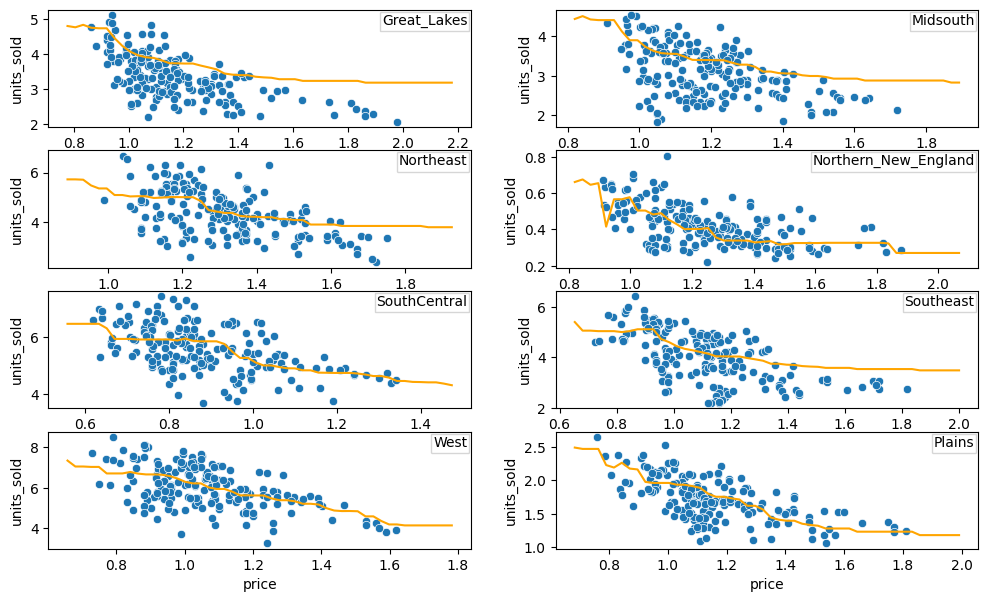

In [31]:
year = 2019
fig, axs = plt.subplots(4, 2, figsize=(12, 7))

for k in range(8):
  r = regions[k]
  i = k//2
  j = k%2
  X_r = df.loc[(df.region==r) & (df.peak==peak_or_not),["price", "year","units_sold"]]
  x_plt = X_r.price
  p_new = np.linspace(.9*min(x_plt),1.1*max(x_plt),50)
  x_new = pd.DataFrame(
      data={
          "year": year,
          "peak": peak_or_not,
          "region": r,
          "price": p_new
      },
      index=range(50)
  )
  x_new['units_sold'] = reg.predict(x_new)
  sns.lineplot(data=x_new, x='price', y='units_sold', c='orange', ax=axs[i,j])
  sns.scatterplot(data=X_r, x='price', y='units_sold',legend=0, ax=axs[i,j])
  axs[i, j].legend(title=r, loc='upper right', prop={'size': 3}, handles = []);

This was in introductory look at using the Gurobi Machine Learning package. For more on this example, see the [Price Optimization example of Github](https://github.com/Gurobi/modeling-examples/tree/master/price_optimization)
as well as how to work with the model interactively.

Copyright © 2023 Gurobi Optimization, LLC